<a href="https://colab.research.google.com/github/svetaepc/ds_py/blob/master/handling_missing_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://bit.ly/FEML-6-HANDLE

## Работа с пропусками


<h1><u>План урока</u></h1>

<p><font size="3" face="Arial">
<ul type="square"><a href="#1"><li>Первичный анализ данных.</li></a><a href="#2"><li>Обработка нулевых значений.</li></a><a href="#3"><li>Практика.</li></a>
    <ul><a href="#4"><li>Первичный анализ.</li></a><a href="#5"><li>Удаление бесполезных признаков.</li></a><a href="#6"><li>Обработка пропущенных значений.</li></a></ul>    
</ul></font></p>

<h2>Первичный анализ данных</h2>
<p id="1">Важнейшим этапом предобработки данных является работа с нулевыми значениями/пропусками, помимо работы с переменными, выбросами и шумом. Все это может существенно улучшить качество модели. При знакомстве с новыми данными практически всегда стоит делать первичный (визуальный) анализ данных.</p>
<p><b>EDA</b> (англ. exploratory data analysis) - это критически важный процесс первоначального исследования данных с помощью  сводной статистики и визуализации с 4 основными целями:<ul><li>Выявить паттерны/закономерности</li><li>Заметить анамолии/шум</li><li>Сформировать гипотезы</li><li>Проверить первичные предположения</li></ul></p>

<div class="alert alert-info"><p><i>Что нас прежде всего интересует при первичном анализе данных?</i>
<ol><li>Как собирались данные?</li><li>Сколько имеется переменных и что они  описывают?</li><li>Что обозначает каждая переменная, какие единицы измерения и как она собирается?</li><li>Есть ли пропущенные значения (NaN'ы, Not Available), и почему они возникли?</li><li>Есть ли выбросы в распределениях?</li><li>Присутствуют ли некие корреляции между переменными?</li></ol></div></p>

<h2>Обработка нулевых значений</h2>
<p id="2">В данном уроке пойдет речь о работе с пропущенными значениями в данных, он будет носить сугубо практический характер. Сразу оговоримся, чего <b>не стоит делать</b>, если Вы видите те или иные пропуски или нулевые значения, там где они быть не должны:
<ul><li>Удалять столбец (признак) содержащий такое значение (значительная потеря информации).</li><li>Удалять строки более безопасно, но только в том случае, если данных достаточно много. Иначе - потеря информации.</li></ul>
<p>Что обычно <b>нужно делать</b> с пропущенными значениями?</p>
<ul><li>Заменять на среднее значение, медиану, моду</li><li>Indicator Method - замена пропущенных значений нулями и создание новой переменной индикатора (где она принимает значение 1 при наличие пропуска и 0 в остальных случаях).</li><li>Повторить результат последнего наблюдения (среднее между соседними).</li><li>Восстановление пропусков на основе моделей.</li></ul>


## Практика
<p id="3">И перейдем сразу к практике. Будем заниматься анализом датасетом стоимости квартир, вносить те или иные изменения и смотреть как это будет влиять на "предсказательную" силу модели.</p>

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd # Для работы с данными
import matplotlib.pyplot as plt  # Библиотека для визуализации результатов
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

### Первичный анализ
<p id="4">Имеем 11330 объектов и 18 признаков. Для начала посмотрим какие признаки у нас есть. Это "адрес", "кол-во ванных комнат","кол-во спален", "влощадь в кв. фут", "последняя цена продажи", и т.д.</p>


In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/flaymax/tmp/master/final_data.csv', delimiter=';')
print(data.shape)
data.head(3)

(11330, 18)


,Unnamed: 0,address,z_address,bathrooms,bedrooms,finishedsqft,lastsolddate,lastsoldprice,latitude,longitude,neighborhood,totalrooms,usecode,yearbuilt,zestimate,zindexvalue,zipcode,zpid
0,2,Address: 1160 Mission Street #2007,1160 Mission St UNIT 2007,2.0,2.0,1043.0,02/17/2016,1300000.0,37.778705,-122.412635,South of Market,4.0,Condominium,2007.0,1167508.0,"975,700",94103.0,83152781.0
1,5,Address: 260 King Street #475,260 King St UNIT 475,1.0,1.0,903.0,02/17/2016,750000.0,37.777641,-122.393417,South of Market,3.0,Condominium,2004.0,823719.0,"975,700",94107.0,69819817.0
2,7,Address: 560 Missouri Street #B,560 Missouri St # B,4.0,3.0,1425.0,02/17/2016,1495000.0,37.759198,-122.396516,Potrero Hill,6.0,Condominium,2003.0,1708594.0,"1,277,600",94107.0,64972847.0


In [ ]:
data.isna().sum()

Unnamed: 0         0
address            0
z_address          0
bathrooms          0
bedrooms           0
finishedsqft     119
lastsolddate       0
lastsoldprice      0
latitude          15
longitude         15
neighborhood       0
totalrooms        49
usecode           40
yearbuilt          0
zestimate          0
zindexvalue        0
zipcode            0
zpid               0
dtype: int64

Будем использовать линейную регрессию для тестирования качества данных. Сразу напишем функцию получения скор (параметр от 0 до 1, который показывает насколько точна наша модель по отношению к таргетной переменной), для удобства.

In [ ]:
def get_score(X, y, random_seed=42, model=None):
    if model is None:
        model = LinearRegression()
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)  
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

Для поиска выбросов будем использовать boxplot, для выявления корреляций между переменными - pairplot.

In [ ]:
def get_boxplot(X, columns=[]):
    for i in columns:
        sns.boxplot(x=X[i])
    pass  

def get_pairplot(X, columns=None):
    if columns is None:
        columns = list(X.columns)
    sns.pairplot(X[columns])
    pass    

Т.к. нам предстоит работать с пропусками, то для их заполнения будем использовать стандартные способы и напишем специальную функцию для этого.
- заполнение значением
- mode
- median
- mean
- метод индикатора
- линейная регрессия

In [ ]:
data['neighborhood'].mode()[0]

'Mission'

In [ ]:
def get_value(X, column, mode='mean', value=0, columns_for_reg=None): 
    if mode == 'value':
        X.loc[X[X[column].isna()].index, column] = value # заполнение значением

    elif mode == 'median':
        X.loc[X[X[column].isna()].index, column] = X[column].median()    # заполнение медианой
    
    elif mode == 'mode':
        X.loc[X[X[column].isna()].index, column] = X[column].mode()[0]   # заполнение модой
    
    elif mode == 'indicator': # метод индикатора (принимает значение 1 при наличие пропуска и 0 в остальных случаях)
        X['ind_'+str(column)] = 0
        X.loc[X[X[column].isna()].index, 'ind_'+str(column)] = 1
        X.loc[X[X[column].isna()].index, column] = 0     
    
    elif mode == 'linreg':   # линейная регрессия
        if columns_for_reg is None:
            cols = list(X.select_dtypes([np.number]).columns) 
            cols.remove(column)
        else:
            cols = columns_for_reg
        X_tmp = X.dropna()
   
        m = LinearRegression().fit(X_tmp[cols], X_tmp[column])
        X.loc[X[X[column].isna()].index, column] = m.predict(X[X[column].isna()][cols])
    
    else:
        X.loc[X[X[column].isna()].index, column] = X[column].mean()  # по умолчанию среднее значение
    
    return X.head()

Первое, что можно сделать при встрече с новыми данными это запустить функцию .info(), которая соберет информацию о датасете (названия признаков, тип данных, кол-во ненулевых значений).

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11330 entries, 0 to 11329
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     11330 non-null  int64  
 1   address        11330 non-null  object 
 2   z_address      11330 non-null  object 
 3   bathrooms      11330 non-null  float64
 4   bedrooms       11330 non-null  float64
 5   finishedsqft   11211 non-null  float64
 6   lastsolddate   11330 non-null  object 
 7   lastsoldprice  11330 non-null  float64
 8   latitude       11315 non-null  float64
 9   longitude      11315 non-null  float64
 10  neighborhood   11330 non-null  object 
 11  totalrooms     11281 non-null  float64
 12  usecode        11290 non-null  object 
 13  yearbuilt      11330 non-null  float64
 14  zestimate      11330 non-null  float64
 15  zindexvalue    11330 non-null  object 
 16  zipcode        11330 non-null  float64
 17  zpid           11330 non-null  float64
dtypes: flo

In [ ]:
data.isna().sum()

Unnamed: 0         0
address            0
z_address          0
bathrooms          0
bedrooms           0
finishedsqft     119
lastsolddate       0
lastsoldprice      0
latitude          15
longitude         15
neighborhood       0
totalrooms        49
usecode           40
yearbuilt          0
zestimate          0
zindexvalue        0
zipcode            0
zpid               0
dtype: int64

Также можно вызвать функцию .describe(), которая подсчитает статистики по всем количественными переменным (кол-во, среднее, дисперсию, квартили и т.д.)

In [ ]:
data.describe()

,Unnamed: 0,bathrooms,bedrooms,finishedsqft,lastsoldprice,latitude,longitude,totalrooms,yearbuilt,zestimate,zipcode,zpid
count,11330.000000,11330.000000,11330.000000,11211.000000,1.133000e+04,11315.000000,11315.000000,11281.000000,11330.000000,1.133000e+04,11330.000000,1.133000e+04
mean,9171.729214,1.980229,2.614475,1586.081349,1.263928e+06,37.759715,-122.436508,6.113997,1948.498147,1.565695e+06,94116.912004,3.689973e+07
std,4921.941074,1.047358,1.299457,922.815803,1.042079e+06,0.025583,0.030742,12.151195,37.911196,1.229417e+06,9.400877,7.800741e+07
min,2.000000,0.500000,0.000000,1.000000,5.350000e+02,37.708170,-122.510726,1.000000,1860.000000,4.323850e+05,94102.000000,1.506329e+07
25%,5039.750000,1.000000,2.000000,1019.000000,7.292500e+05,37.739284,-122.455149,4.000000,1916.000000,9.052375e+05,94110.000000,1.510847e+07
50%,9198.500000,2.000000,2.000000,1362.000000,9.900000e+05,37.760514,-122.432510,5.000000,1940.000000,1.230758e+06,94115.000000,1.515697e+07
75%,13374.750000,2.000000,3.000000,1878.000000,1.450000e+06,37.781386,-122.413353,7.000000,1986.000000,1.731170e+06,94123.000000,5.970040e+07
max,17632.000000,14.000000,20.000000,27275.000000,2.388900e+07,37.806083,-122.381201,1264.000000,2016.000000,1.553325e+07,94158.000000,2.146999e+09


Отсюда уже сразу можно увидеть выбросы. Например, видим, что имеется квартира с 1264 комнатами, квартира площадью 1 кв.фут, квартира стоимостью 535$ и т.д.

### Удаление бесполезных признаков
<p id="5">Рассмотрим на первый взгляд непонятный признак 'Unnamed: 0'. Проверим предположении, что это какой-то технический номер, который остался после формирования датасета, и на стоимость квартир влиять не будет.</p>

In [ ]:
data['Unnamed: 0'].value_counts(dropna=False)

2        1
11984    1
12018    1
12019    1
12020    1
        ..
6536     1
6538     1
6539     1
6540     1
17632    1
Name: Unnamed: 0, Length: 11330, dtype: int64

Видим, что зависимость линейная и эта колонка не представляет интереса. Ее можно удалить.

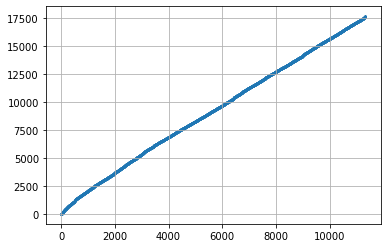

In [ ]:
plt.scatter(data.index, data['Unnamed: 0'], s=1)
plt.grid()

In [ ]:
data.drop(columns=['Unnamed: 0'], inplace=True)

Также можно выбросить колонки 'zindexvalue', 'zpid' т.к. это артефакты, которые остались после оценки zestimate, которые никак не влияют на оценку стоимости квартиры.

In [ ]:
data.drop(columns=['zindexvalue', 'zpid'], inplace=True)

Итого имеем 15 признаков (используем .columns). И теперь можно заняться пропущенными значениями и дальнейшим анализом.

In [ ]:
data.columns

Index(['address', 'z_address', 'bathrooms', 'bedrooms', 'finishedsqft',
       'lastsolddate', 'lastsoldprice', 'latitude', 'longitude',
       'neighborhood', 'totalrooms', 'usecode', 'yearbuilt', 'zestimate',
       'zipcode'],
      dtype='object')

### Обработка пропущенных значений
<p id="6">Для начала посмотрим какое значение выдаст наша функция get_score без всяческой обработки, на сырых данных. Будем считать этот результат базовым.</p>

In [ ]:
cols = ['bathrooms', 'bedrooms', 'finishedsqft', 
        'lastsoldprice', 'latitude', 'longitude',
        'totalrooms', 'yearbuilt']
target = ['zestimate']

get_score(data.dropna()[cols], data.dropna()[target])

0.8275249613455233

Сначала посмотрим выбросы, а после этого будем заполнять пропущенные значения. Возьмем признак площади квартиры. Построим боксплот и посмотрим распределение.

#### finishedsqft

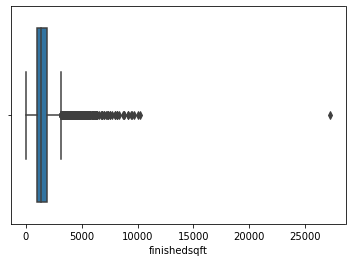

In [ ]:
get_boxplot(data, columns=['finishedsqft'])
# IQR = q3 - q1
# q1 - 1.5 * IQR
# q3 + 1.5 * IQR

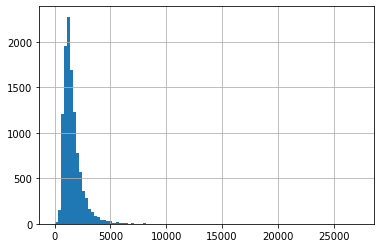

In [ ]:
data['finishedsqft'].hist(bins=100)
plt.show()

Видим явный выброс на боксплоте. Это явная ошибка при заполнении данных. Если посмотреть на этот объект подробнее, то можно увидеть, что на 6 комнат приходится 27275 кв. фут.

In [ ]:
data[data['finishedsqft'] > 15000]

,address,z_address,bathrooms,bedrooms,finishedsqft,lastsolddate,lastsoldprice,latitude,longitude,neighborhood,totalrooms,usecode,yearbuilt,zestimate,zipcode
4997,Address: 1645 Pacific Avenue,1645 Pacific Ave,2.0,2.0,27275.0,03/31/2015,600000.0,37.794658,-122.422325,Nob Hill,6.0,Condominium,1906.0,6754185.0,94109.0


Удаляем выброс и заполняем нулевые значения методом линейной регрессии.

In [ ]:
data = data[(data['finishedsqft'] < 15000) | (data['finishedsqft'].isna())]
data[data['finishedsqft'] > 15000]

,address,z_address,bathrooms,bedrooms,finishedsqft,lastsolddate,lastsoldprice,latitude,longitude,neighborhood,totalrooms,usecode,yearbuilt,zestimate,zipcode


In [ ]:
data['finishedsqft'].isna().sum()

119

In [ ]:
get_value(X=data,
          column='finishedsqft',
          mode='linreg',
          columns_for_reg=['bathrooms', 'bedrooms', 'lastsoldprice', 'latitude', 'longitude', 'yearbuilt'])

,address,z_address,bathrooms,bedrooms,finishedsqft,lastsolddate,lastsoldprice,latitude,longitude,neighborhood,totalrooms,usecode,yearbuilt,zestimate,zipcode
0,Address: 1160 Mission Street #2007,1160 Mission St UNIT 2007,2.0,2.0,1043.0,02/17/2016,1300000.0,37.778705,-122.412635,South of Market,4.0,Condominium,2007.0,1167508.0,94103.0
1,Address: 260 King Street #475,260 King St UNIT 475,1.0,1.0,903.0,02/17/2016,750000.0,37.777641,-122.393417,South of Market,3.0,Condominium,2004.0,823719.0,94107.0
2,Address: 560 Missouri Street #B,560 Missouri St # B,4.0,3.0,1425.0,02/17/2016,1495000.0,37.759198,-122.396516,Potrero Hill,6.0,Condominium,2003.0,1708594.0,94107.0
3,Address: 350 Missouri Street,350 Missouri St,3.0,3.0,2231.0,02/17/2016,2700000.0,37.761886,-122.396769,Potrero Hill,10.0,SingleFamily,1927.0,2411236.0,94107.0
4,Address: 3658 Folsom Street,3658 Folsom St,3.0,3.0,1300.0,02/17/2016,1530000.0,37.740795,-122.413453,Bernal Heights,4.0,SingleFamily,1900.0,1918539.0,94110.0


In [ ]:
data.isna().sum()

address           0
z_address         0
bathrooms         0
bedrooms          0
finishedsqft      0
lastsolddate      0
lastsoldprice     0
latitude         15
longitude        15
neighborhood      0
totalrooms       49
usecode          40
yearbuilt         0
zestimate         0
zipcode           0
dtype: int64

#### latitude и longitude

Посмотрим на широтy и долготу. Видим, что во всех выбросах широты и долготы, пропущены сразу оба значения. Нет объектов, где пропущено что-то одно (берем индексы NaN'ов из широты, делаем из них множество и вычетаем множество индексов NaN'ов долготы, получаем пустое множество).

In [ ]:
set(data[data['latitude'].isna()].index) - set(data[data['longitude'].isna()].index)

set()

In [ ]:
data[data['latitude'].isna()]

,address,z_address,bathrooms,bedrooms,finishedsqft,lastsolddate,lastsoldprice,latitude,longitude,neighborhood,totalrooms,usecode,yearbuilt,zestimate,zipcode
830,Address: 1566 27th Avenue,1566 27th Ave,3.5,3.0,2050.0,10/22/2015,1320000.0,NaN,NaN,Central Sunset,6.0,SingleFamily,1931.0,1371619.0,94122.0
2120,Address: 2033 Judah Street,2033-2035 Judah St,4.0,4.0,2500.0,05/22/2015,1480000.0,NaN,NaN,Central Sunset,12.0,MultiFamily2To4,1948.0,1533582.0,94122.0
2360,Address: 465 Myra Way,465 Myra Way,2.5,3.0,1800.0,04/24/2015,1260000.0,NaN,NaN,Miraloma Park,6.0,SingleFamily,1962.0,1290743.0,94127.0
5150,Address: 2342 Octavia Street,2342 Octavia St,3.5,4.0,2857.0,05/21/2014,3700000.0,NaN,NaN,Pacific Heights,7.0,SingleFamily,1939.0,4814430.0,94109.0
5835,Address: 3189 Cesar Chavez #2,3189 Cesar Chavez # 2,2.0,3.0,1807.0,03/25/2014,775000.0,NaN,NaN,Bernal Heights,6.0,Condominium,1981.0,2045775.0,94110.0
7987,Address: 331 Capistrano Avenue,331 Capistrano Ave,2.0,4.0,1668.0,08/09/2013,803000.0,NaN,NaN,Mission Terrace,9.0,SingleFamily,1925.0,1180548.0,94112.0
8307,Address: 5853 Mission Street #4,5853 Mission St APT 4,1.0,2.0,780.0,01/30/2015,350000.0,NaN,NaN,Crocker Amazon,5.0,Condominium,1980.0,558681.0,94112.0
8651,Address: 3438 Taraval Street,3438 Taraval St,2.0,1.0,1062.0,04/23/2013,650000.0,NaN,NaN,Outer Parkside,5.0,SingleFamily,1941.0,887624.0,94116.0
9108,Address: 1 South Park Street #305,1 S Park St APT 305,2.0,2.0,1374.0,02/28/2013,1500000.0,NaN,NaN,South Beach,5.0,Condominium,2007.0,1859234.0,94107.0
9517,Address: 1021 Divisadero Street,1021-1023 Divisadero St,2.0,7.0,2950.0,12/28/2012,392500.0,NaN,NaN,North Panhandle,11.0,MultiFamily2To4,1900.0,2270942.0,94115.0


Посмотрим есть ли у этих квартир пересечения по адресу с другими. Видим пересечение только у 3 объектов. Их можно заполнить скопировав широту и долготу.

In [ ]:
set(data[data['latitude'].isna()]['z_address']) & set(data[~data['latitude'].isna()]['z_address'])

{'1015 Ashbury St APT 2', '1566 27th Ave', '5853 Mission St APT 4'}

In [ ]:
data[data['z_address'] == '1015 Ashbury St APT 2']

,address,z_address,bathrooms,bedrooms,finishedsqft,lastsolddate,lastsoldprice,latitude,longitude,neighborhood,totalrooms,usecode,yearbuilt,zestimate,zipcode
61,Address: 1015 Ashbury Street #2,1015 Ashbury St APT 2,2.0,2.0,1252.000000,02/05/2016,1350000.0,37.76432,-122.446342,Parnassus - Ashbury,4.0,Condominium,1913.0,1300995.0,94117.0
8551,Address: 1015 Ashbury Street #2,1015 Ashbury St APT 2,2.0,2.0,1252.000000,02/05/2016,1350000.0,37.76432,-122.446342,Parnassus - Ashbury,4.0,Condominium,1913.0,1319182.0,94117.0
9375,Address: 1015 Ashbury Street #2,1015 Ashbury St APT 2,2.0,2.0,1563.642786,02/05/2016,1350000.0,37.76432,-122.446342,Parnassus - Ashbury,4.0,Condominium,1913.0,1319182.0,94117.0
11314,Address: 1015 Ashbury Street #2,1015 Ashbury St APT 2,2.0,2.0,1252.000000,02/05/2016,1350000.0,NaN,NaN,Parnassus - Ashbury,NaN,Condominium,1913.0,1320620.0,94117.0


In [ ]:
for i, el in data[data['latitude'].isna()].iterrows():
    cur_el = data[data['z_address'] == el['z_address']]
    if cur_el.shape[0] > 0:
        data.loc[i, 'latitude'] = cur_el.iloc[0]['latitude']
        data.loc[i, 'longitude'] = cur_el.iloc[0]['longitude']

In [ ]:
data[data['z_address'] == '1015 Ashbury St APT 2']

,address,z_address,bathrooms,bedrooms,finishedsqft,lastsolddate,lastsoldprice,latitude,longitude,neighborhood,totalrooms,usecode,yearbuilt,zestimate,zipcode
61,Address: 1015 Ashbury Street #2,1015 Ashbury St APT 2,2.0,2.0,1252.000000,02/05/2016,1350000.0,37.76432,-122.446342,Parnassus - Ashbury,4.0,Condominium,1913.0,1300995.0,94117.0
8551,Address: 1015 Ashbury Street #2,1015 Ashbury St APT 2,2.0,2.0,1252.000000,02/05/2016,1350000.0,37.76432,-122.446342,Parnassus - Ashbury,4.0,Condominium,1913.0,1319182.0,94117.0
9375,Address: 1015 Ashbury Street #2,1015 Ashbury St APT 2,2.0,2.0,1563.642786,02/05/2016,1350000.0,37.76432,-122.446342,Parnassus - Ashbury,4.0,Condominium,1913.0,1319182.0,94117.0
11314,Address: 1015 Ashbury Street #2,1015 Ashbury St APT 2,2.0,2.0,1252.000000,02/05/2016,1350000.0,37.76432,-122.446342,Parnassus - Ashbury,NaN,Condominium,1913.0,1320620.0,94117.0


In [ ]:
data[data['latitude'].isna()]

,address,z_address,bathrooms,bedrooms,finishedsqft,lastsolddate,lastsoldprice,latitude,longitude,neighborhood,totalrooms,usecode,yearbuilt,zestimate,zipcode
830,Address: 1566 27th Avenue,1566 27th Ave,3.5,3.0,2050.0,10/22/2015,1320000.0,NaN,NaN,Central Sunset,6.0,SingleFamily,1931.0,1371619.0,94122.0
2120,Address: 2033 Judah Street,2033-2035 Judah St,4.0,4.0,2500.0,05/22/2015,1480000.0,NaN,NaN,Central Sunset,12.0,MultiFamily2To4,1948.0,1533582.0,94122.0
2360,Address: 465 Myra Way,465 Myra Way,2.5,3.0,1800.0,04/24/2015,1260000.0,NaN,NaN,Miraloma Park,6.0,SingleFamily,1962.0,1290743.0,94127.0
5150,Address: 2342 Octavia Street,2342 Octavia St,3.5,4.0,2857.0,05/21/2014,3700000.0,NaN,NaN,Pacific Heights,7.0,SingleFamily,1939.0,4814430.0,94109.0
5835,Address: 3189 Cesar Chavez #2,3189 Cesar Chavez # 2,2.0,3.0,1807.0,03/25/2014,775000.0,NaN,NaN,Bernal Heights,6.0,Condominium,1981.0,2045775.0,94110.0
7987,Address: 331 Capistrano Avenue,331 Capistrano Ave,2.0,4.0,1668.0,08/09/2013,803000.0,NaN,NaN,Mission Terrace,9.0,SingleFamily,1925.0,1180548.0,94112.0
8651,Address: 3438 Taraval Street,3438 Taraval St,2.0,1.0,1062.0,04/23/2013,650000.0,NaN,NaN,Outer Parkside,5.0,SingleFamily,1941.0,887624.0,94116.0
9108,Address: 1 South Park Street #305,1 S Park St APT 305,2.0,2.0,1374.0,02/28/2013,1500000.0,NaN,NaN,South Beach,5.0,Condominium,2007.0,1859234.0,94107.0
9517,Address: 1021 Divisadero Street,1021-1023 Divisadero St,2.0,7.0,2950.0,12/28/2012,392500.0,NaN,NaN,North Panhandle,11.0,MultiFamily2To4,1900.0,2270942.0,94115.0
9879,Address: 970 Wisconsin Street #1,970 Wisconsin St # 1,2.0,3.0,825.0,11/21/2012,649000.0,NaN,NaN,Potrero Hill,5.0,Condominium,1992.0,890937.0,94107.0


Для других объектов заполним пропущенные значения медианой по принадлежности району. Для этого получим уникальные сочетания почтовых индексов и районов, и выведем для этих сочетаний медианные значения широты и долготы.

In [ ]:
data_long_lat = data.groupby(['zipcode', 'neighborhood']).agg(
    {'latitude': 'median',
     'longitude': 'median'}
).reset_index()
data_long_lat

,zipcode,neighborhood,latitude,longitude
0,94102.0,Downtown,37.786190,-122.407630
1,94102.0,Hayes Valley,37.772243,-122.426551
2,94102.0,Van Ness - Civic Center,37.781386,-122.421406
3,94103.0,Mission,37.766736,-122.421846
4,94103.0,South of Market,37.775993,-122.411809
...,...,...,...,...
124,94134.0,Excelsior,37.728280,-122.423571
125,94134.0,Little Hollywood,37.712230,-122.398930
126,94134.0,Portola,37.726208,-122.411113
127,94134.0,Visitacion Valley,37.714392,-122.405860


In [ ]:
for i, el in data[data['latitude'].isna()].iterrows():
    data.loc[i, 'latitude'] = data_long_lat[
        (data_long_lat['zipcode'] == el['zipcode']) 
        & (data_long_lat['neighborhood'] == el['neighborhood'])
    ]['latitude'].values[0]

    data.loc[i, 'longitude'] = data_long_lat[
        (data_long_lat['zipcode'] == el['zipcode'])
         & (data_long_lat['neighborhood'] == el['neighborhood'])
    ]['longitude'].values[0]

In [ ]:
data.isna().sum()

address           0
z_address         0
bathrooms         0
bedrooms          0
finishedsqft      0
lastsolddate      0
lastsoldprice     0
latitude          0
longitude         0
neighborhood      0
totalrooms       49
usecode          40
yearbuilt         0
zestimate         0
zipcode           0
dtype: int64

Видим, что широту и долготу заполнили. Посмотрим на промежуточный скор.

В результате этих манипуляций подняли скор на 2%.

In [ ]:
get_score(data.dropna()[cols], data.dropna()[target])

0.8406653093454883

#### totalrooms

Теперь посмотрим признак "totalrooms". Для начала надо убрать выбросы. Строим для этого боксплот.

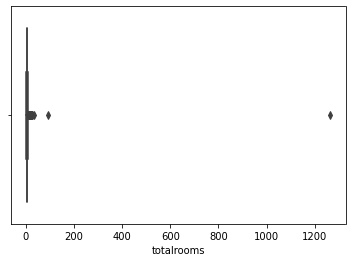

In [ ]:
get_boxplot(data, ['totalrooms'])

Видим 2 явных выброса. Имеется объект с 94 комнатами на 805 кв. футов и 1264 комнатами на 1264 кв. фута. Удаляем их, скорее всего это ошибка ручного ввода.

In [ ]:
data[data['totalrooms'] > 75]

,address,z_address,bathrooms,bedrooms,finishedsqft,lastsolddate,lastsoldprice,latitude,longitude,neighborhood,totalrooms,usecode,yearbuilt,zestimate,zipcode
8300,Address: 5264 3rd Street #304,5264 3rd St APT 304,2.0,2.0,805.0,07/18/2013,325000.0,37.729825,-122.392825,Bayview,94.0,Condominium,1993.0,502285.0,94124.0
8967,Address: 2829 California Street #3C,2829 California St APT 3C,2.0,2.0,1264.0,03/14/2013,1375000.0,37.787654,-122.440902,Lower Pacific Heights,1264.0,Condominium,2012.0,1591608.0,94115.0


In [ ]:
data = data[(data['totalrooms'] < 75) | (data['totalrooms'].isna())]

Теперь заполним пропущенные значения с помощью метода линейной регрессии.

In [ ]:
get_value(X=data,
          column='totalrooms',
          mode='linreg',
          columns_for_reg=['bathrooms', 'bedrooms', 'lastsoldprice', 'latitude', 'longitude', 'yearbuilt', 'finishedsqft'])

,address,z_address,bathrooms,bedrooms,finishedsqft,lastsolddate,lastsoldprice,latitude,longitude,neighborhood,totalrooms,usecode,yearbuilt,zestimate,zipcode
0,Address: 1160 Mission Street #2007,1160 Mission St UNIT 2007,2.0,2.0,1043.0,02/17/2016,1300000.0,37.778705,-122.412635,South of Market,4.0,Condominium,2007.0,1167508.0,94103.0
1,Address: 260 King Street #475,260 King St UNIT 475,1.0,1.0,903.0,02/17/2016,750000.0,37.777641,-122.393417,South of Market,3.0,Condominium,2004.0,823719.0,94107.0
2,Address: 560 Missouri Street #B,560 Missouri St # B,4.0,3.0,1425.0,02/17/2016,1495000.0,37.759198,-122.396516,Potrero Hill,6.0,Condominium,2003.0,1708594.0,94107.0
3,Address: 350 Missouri Street,350 Missouri St,3.0,3.0,2231.0,02/17/2016,2700000.0,37.761886,-122.396769,Potrero Hill,10.0,SingleFamily,1927.0,2411236.0,94107.0
4,Address: 3658 Folsom Street,3658 Folsom St,3.0,3.0,1300.0,02/17/2016,1530000.0,37.740795,-122.413453,Bernal Heights,4.0,SingleFamily,1900.0,1918539.0,94110.0


In [ ]:
data.isna().sum()

address           0
z_address         0
bathrooms         0
bedrooms          0
finishedsqft      0
lastsolddate      0
lastsoldprice     0
latitude          0
longitude         0
neighborhood      0
totalrooms        0
usecode          40
yearbuilt         0
zestimate         0
zipcode           0
dtype: int64

#### usecode

Осталось заполнить usecode. Имеем 40 пропусков.

In [ ]:
data['usecode'].value_counts(dropna=False)

SingleFamily        5785
Condominium         4779
MultiFamily2To4      484
Duplex               146
Townhouse             66
NaN                   40
Miscellaneous         17
Apartment              3
Cooperative            3
Mobile                 2
MultiFamily5Plus       2
Name: usecode, dtype: int64

Разметим наши данные колонки 'usecode' с помощью LabelEncoder, а затем обучим логистическую регрессию на них и получим предсказанные значения.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

In [ ]:
X_tmp = data.dropna()
X_tmp.head(3)

,address,z_address,bathrooms,bedrooms,finishedsqft,lastsolddate,lastsoldprice,latitude,longitude,neighborhood,totalrooms,usecode,yearbuilt,zestimate,zipcode
0,Address: 1160 Mission Street #2007,1160 Mission St UNIT 2007,2.0,2.0,1043.0,02/17/2016,1300000.0,37.778705,-122.412635,South of Market,4.0,Condominium,2007.0,1167508.0,94103.0
1,Address: 260 King Street #475,260 King St UNIT 475,1.0,1.0,903.0,02/17/2016,750000.0,37.777641,-122.393417,South of Market,3.0,Condominium,2004.0,823719.0,94107.0
2,Address: 560 Missouri Street #B,560 Missouri St # B,4.0,3.0,1425.0,02/17/2016,1495000.0,37.759198,-122.396516,Potrero Hill,6.0,Condominium,2003.0,1708594.0,94107.0


In [ ]:
X_tmp.isna().sum()

address          0
z_address        0
bathrooms        0
bedrooms         0
finishedsqft     0
lastsolddate     0
lastsoldprice    0
latitude         0
longitude        0
neighborhood     0
totalrooms       0
usecode          0
yearbuilt        0
zestimate        0
zipcode          0
dtype: int64

In [ ]:
le = LabelEncoder()
X_tmp['usecode_target'] = le.fit_transform(X_tmp['usecode'])
X_tmp.head()

,address,z_address,bathrooms,bedrooms,finishedsqft,lastsolddate,lastsoldprice,latitude,longitude,neighborhood,totalrooms,usecode,yearbuilt,zestimate,zipcode,usecode_target
0,Address: 1160 Mission Street #2007,1160 Mission St UNIT 2007,2.0,2.0,1043.0,02/17/2016,1300000.0,37.778705,-122.412635,South of Market,4.0,Condominium,2007.0,1167508.0,94103.0,1
1,Address: 260 King Street #475,260 King St UNIT 475,1.0,1.0,903.0,02/17/2016,750000.0,37.777641,-122.393417,South of Market,3.0,Condominium,2004.0,823719.0,94107.0,1
2,Address: 560 Missouri Street #B,560 Missouri St # B,4.0,3.0,1425.0,02/17/2016,1495000.0,37.759198,-122.396516,Potrero Hill,6.0,Condominium,2003.0,1708594.0,94107.0,1
3,Address: 350 Missouri Street,350 Missouri St,3.0,3.0,2231.0,02/17/2016,2700000.0,37.761886,-122.396769,Potrero Hill,10.0,SingleFamily,1927.0,2411236.0,94107.0,8
4,Address: 3658 Folsom Street,3658 Folsom St,3.0,3.0,1300.0,02/17/2016,1530000.0,37.740795,-122.413453,Bernal Heights,4.0,SingleFamily,1900.0,1918539.0,94110.0,8


Обучаем логистическую регрессию.

In [ ]:
logreg = LogisticRegression()
cols = ['bathrooms', 'bedrooms', 'finishedsqft', 
        'lastsoldprice', 'latitude', 'longitude',
        'totalrooms', 'yearbuilt']

logreg.fit(X_tmp[cols], X_tmp['usecode_target'])

LogisticRegression()

Делаем обратное преобразование LabelEncoder и получаем предсказанные данные.

In [ ]:
preds = logreg.predict(data[data['usecode'].isna()][cols])
preds

array([8, 8, 1, 1, 1, 8, 8, 1, 8, 8, 8, 8, 8, 1, 1, 1, 8, 8, 8, 8, 8, 1,
       8, 8, 1, 8, 8, 8, 1, 1, 8, 8, 1, 1, 1, 1, 8, 8, 8, 8])

In [ ]:
preds_cat = le.inverse_transform(preds)
preds_cat

array(['SingleFamily', 'SingleFamily', 'Condominium', 'Condominium',
       'Condominium', 'SingleFamily', 'SingleFamily', 'Condominium',
       'SingleFamily', 'SingleFamily', 'SingleFamily', 'SingleFamily',
       'SingleFamily', 'Condominium', 'Condominium', 'Condominium',
       'SingleFamily', 'SingleFamily', 'SingleFamily', 'SingleFamily',
       'SingleFamily', 'Condominium', 'SingleFamily', 'SingleFamily',
       'Condominium', 'SingleFamily', 'SingleFamily', 'SingleFamily',
       'Condominium', 'Condominium', 'SingleFamily', 'SingleFamily',
       'Condominium', 'Condominium', 'Condominium', 'Condominium',
       'SingleFamily', 'SingleFamily', 'SingleFamily', 'SingleFamily'],
      dtype=object)

Заполняем ими пропуски.

In [ ]:
data.loc[data[data['usecode'].isna()].index, 'usecode'] = preds_cat

В итоге, все пропуски во всех признаках заполнены, задача выполнена.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11327 entries, 0 to 11329
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   address        11327 non-null  object 
 1   z_address      11327 non-null  object 
 2   bathrooms      11327 non-null  float64
 3   bedrooms       11327 non-null  float64
 4   finishedsqft   11327 non-null  float64
 5   lastsolddate   11327 non-null  object 
 6   lastsoldprice  11327 non-null  float64
 7   latitude       11327 non-null  float64
 8   longitude      11327 non-null  float64
 9   neighborhood   11327 non-null  object 
 10  totalrooms     11327 non-null  float64
 11  usecode        11327 non-null  object 
 12  yearbuilt      11327 non-null  float64
 13  zestimate      11327 non-null  float64
 14  zipcode        11327 non-null  float64
dtypes: float64(10), object(5)
memory usage: 1.6+ MB


In [ ]:
data = pd.get_dummies(data, columns=['usecode'])
data.head()

,address,z_address,bathrooms,bedrooms,finishedsqft,lastsolddate,lastsoldprice,latitude,longitude,neighborhood,...,usecode_Apartment,usecode_Condominium,usecode_Cooperative,usecode_Duplex,usecode_Miscellaneous,usecode_Mobile,usecode_MultiFamily2To4,usecode_MultiFamily5Plus,usecode_SingleFamily,usecode_Townhouse
0,Address: 1160 Mission Street #2007,1160 Mission St UNIT 2007,2.0,2.0,1043.0,02/17/2016,1300000.0,37.778705,-122.412635,South of Market,...,0,1,0,0,0,0,0,0,0,0
1,Address: 260 King Street #475,260 King St UNIT 475,1.0,1.0,903.0,02/17/2016,750000.0,37.777641,-122.393417,South of Market,...,0,1,0,0,0,0,0,0,0,0
2,Address: 560 Missouri Street #B,560 Missouri St # B,4.0,3.0,1425.0,02/17/2016,1495000.0,37.759198,-122.396516,Potrero Hill,...,0,1,0,0,0,0,0,0,0,0
3,Address: 350 Missouri Street,350 Missouri St,3.0,3.0,2231.0,02/17/2016,2700000.0,37.761886,-122.396769,Potrero Hill,...,0,0,0,0,0,0,0,0,1,0
4,Address: 3658 Folsom Street,3658 Folsom St,3.0,3.0,1300.0,02/17/2016,1530000.0,37.740795,-122.413453,Bernal Heights,...,0,0,0,0,0,0,0,0,1,0


Видим, что итоговый результат улучшился на 3%.

In [ ]:
cols_to_drop = ['address', 'z_address', 'lastsolddate', 'neighborhood', 'zipcode']
get_score(data.drop(columns=cols_to_drop).drop(columns=target), data.drop(columns=cols_to_drop)[target])

0.8527334299342646

<h2>Summary</h2>
<ol><li>Первичный <b>визуальный анализ</b> данных очень <b>важен</b> для выявления <b>выбросов/шума</b>, корреляций между признаками, что может значительно <b>ухудшить</b> эффективность модели.</li><li><b>Не стоит</b> сразу <b>удалять</b> столбец или строку, если в ней п<b>ропущенное значение</b>, это может повлечь потерю информации. В зависимости от ситуации, пропуск можно <b>заменить</b> медианой, средним, модой или индикатором.</li></ol>

## **Дополнительные материалы:**
1. Что делать с пропусками https://youtu.be/lg3H1Kd0E4o
2. Работа с пропусками в pandas https://youtu.be/cmvLTIBI_eY
3. Работа с пропусками в sklearn https://youtu.be/o3MuMzaVglI

<h1>Спасибо за внимание!</h1>